In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Validation
A separate validation set is needed because what we have done in picking a given polynomial degree $d$ as the best hypothesis is that we have used the test set as a training set. 

#### How?

1. Our process used the training set to find $\Theta$ for a given $d$ based on ONLY minimizing the traing set error (ERM: empirical risk minimization). 
1. We then calculated the error on the test set at that $d$. 
1. If we go further and choose the best $d$ -- even if it gives the smallest "test error". The selection of $d$ is still based on minimizing the training set error
1. In this case, the test-set error will underestimate the true out-of-sample error. Furthermore, we have contaminated the test set by fitting for $d$ on it; it is no longer a true test set.


###### Thus, a new validation set on which the complexity parameter $d$ is fit.
Leave out a test set, we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

In [3]:
df = pd.read_csv("noisysample.csv")
df.head() 

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


In [5]:
## validation
## the data preparation is similar
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = \
            PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = \
            PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist


datasize=df.shape[0]
## split dataset as before
itrain,itest = train_test_split(range(datasize),\
                                train_size=24, test_size=6)
## xtrain and test are the same for noisy/noiesless
xtrain = df.x[itrain].values
xtest  = df.x[itest].values

## noiseless
ftrain = df.f[itrain].values
ftest  = df.f[itest].values

## noise
ytrain = df.y[itrain].values
ytest  = df.y[itest].values



2


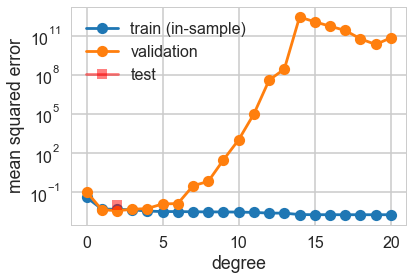

In [10]:
## Now, we further get cross validation split itrain 

intrain,invalid = train_test_split(itrain,\
                                   train_size=18, test_size=6)

## Now we have xntrain and validation 
xntrain= df.x[intrain].values
xnvalid= df.x[invalid].values

## noiseless
fntrain = df.f[intrain].values
fnvalid = df.f[invalid].values

## noise

yntrain = df.y[intrain].values
ynvalid = df.y[invalid].values



## instead, we have error for validation
degrees=range(21)
error_train    = np.empty(len(degrees))
error_valid    = np.empty(len(degrees))
trainvalidlists= make_features(xntrain, xnvalid, degrees)

#we now train on the smaller training set
for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    #Here the test case is "validation case"
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid)
ttlist = make_features(xtrain, xtest, degrees)
features_at_mindeg       = ttlist[mindeg]['train']
test_features_at_mindeg  = ttlist[mindeg]['test']
clf = LinearRegression()
clf.fit(features_at_mindeg, ytrain) # fit
pred = clf.predict(test_features_at_mindeg)
err = mean_squared_error(ytest, pred)
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print(mindeg)

## This method for different train split will get different degree


## If you run the above validation twice, you will find different mindeg, This method for different train split will get different degree.

The problem
1. For small data sizes here, a given split exposes us to the special pattern of the data set that got randomly chosen for us. This  leads us to want to choose **multiple** such random splits and  average over this process to find the **“best” validation minimizing polynomial degree or complexity d.**
1. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: it gives us a distribution. Choosing multiple splits is another way to get different training samples..
1. The validation set that we left out has two competing demands on it. 
        1.The larger the set is, the better is our estimate of the out-of-sample error. So we’d like to hold out as much as possible. 
        1. But the smaller the validation set is, the more data we have to train the model on. Thus we can fit a better, more expressive model. 
    
We want to balance these two desires, and additionally, not be exposed to any peculiarities that might randomly arise in any single train-validate split of the old training set.


You will see the cross validation procedure as below.

In [14]:
from sklearn.model_selection import KFold

n_folds = 4
degrees = range(21)
results = []

## split data into train/cross validation groups, 
## len(xtrain) is 24, n_folds = 4 ,in total 4 groups,
## each is of the form eg: train: [0,1...,18], validation[19,20,..24]

tvlist_list = []
kf =  KFold(n_folds)
for train, test in kf.split(np.arange(24)): 
    tvlist = make_features(xtrain[train], xtrain[test], degrees)
    tvlist_list.append(tvlist)
    
for d in degrees:
    hypothesisresults=[]
    ## for every degree d, 
    ## train and test through all validation sets
    i = 0
    for train, test in kf.split(np.arange(24)): 
        tvlist = tvlist_list[i]
        clf    = LinearRegression()
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test],clf.predict(tvlist[d]['test'])))
        i += 1

    results.append((np.mean(hypothesisresults), \
                    np.min(hypothesisresults), \
                    np.max(hypothesisresults), \
                    np.std(hypothesisresults))) 



In [15]:
## find the smallest error
mindeg = np.argmin([r[0] for r in results])

## Now use all 24 training examples
ttlist=make_features(xtrain, xtest, degrees)

#fit on whole training set now.
#using the best training mindeg
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred  = clf.predict(ttlist[mindeg]['test'])
err   = mean_squared_error(pred, ytest)
errtr = mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))

## training weight = len(xtrain)/datasize
## test weight = len(xtest)/datasize
wttr = len(xtrain)/datasize
wter = len(xtest)/datasize
errout= wttr*errtr+wter*err

In [16]:
print(mindeg)

2


### recall that our results contain the following information: for each degree d, results[d] = [mean err, min err, max err, std err]

2
[ 0.          1.21286467 -0.2766171 ]


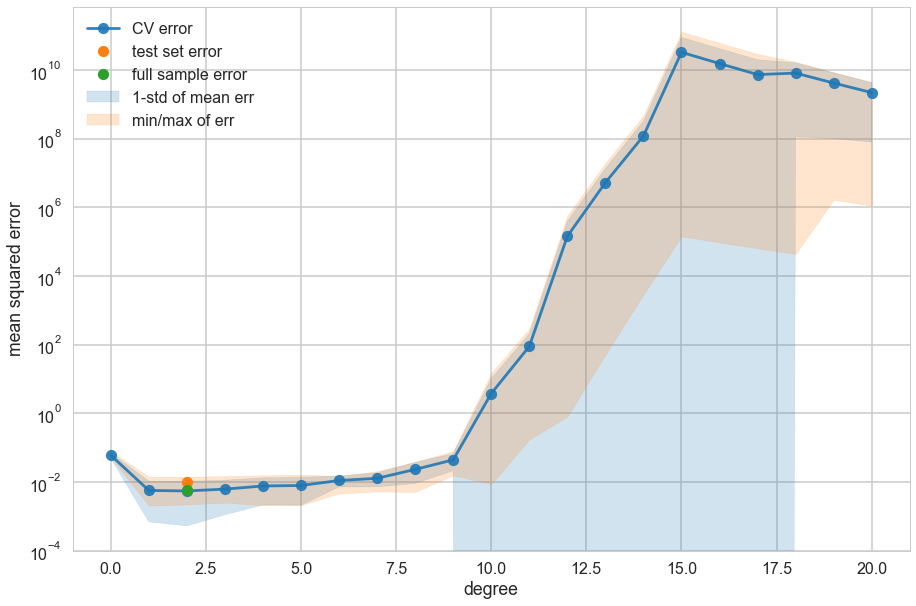

In [17]:
## plot results

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
#plt.errorbar(degrees, [r[0] for r in results], 
# yerr=[r[1] for r in results], marker='o', 
# label='CV error', alpha=0.5)

plt.figure(figsize=(15,10))
plt.plot(degrees, [r[0] for r in results], marker='o', label='CV error', alpha=0.9)


plt.fill_between(degrees, [r[0]-r[3] for r in results],\
                 [r[0]+r[3] for r in results], \
                 color=c0, alpha=0.2,label = "1-std of mean err")

plt.fill_between(degrees, [r[1] for r in results],\
                 [r[2] for r in results], \
                 color=c1, alpha=0.2, label = "min/max of err")


plt.plot([mindeg], [err], 'o',  label='test set error')
plt.plot([mindeg], [errout], 'o',  label='full sample error')


plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print(mindeg)
print(clf.coef_.ravel())

What does Cross Validation do?
One can think about the validation process as **one that estimates Rout directly**, on the validation set. 

It's crutial for the model selection process. Once you do that you can estimate **Rout** using the test set as usual, but now you have also got the benefit of a robust average and error bars.

One key subtlety to remember about **cross-validation** is that in the **risk averaging process you are actually averaging over different models, with different parameters**. 

You arrive at the least risk for the hyperparameter and then **refit on the entire training set**, which will likely give you slightly different parameters as well.